## Imports

In [1]:
import numpy as np
import torch

## Configuration

In [2]:
from omegaconf import OmegaConf

CONFIG = OmegaConf.create({
    # Model
    "model": "WideResNet-28-10-torchdistill",
    "num_classes": 10,
    # Dataset
    "image_size": 32,
    "pure_noise_mean": [0.4988, 0.5040, 0.4926],
    "pure_noise_std": [0.2498, 0.2480, 0.2718],
    "per_class_count": 50,
    "valid_transform_reprs": [
        "ConvertImageDtype(float)",
        "Normalize((0.4988, 0.5040, 0.4926), (0.2498, 0.2480, 0.2718))",
    ],
    "batch_size": 128,
    "num_workers": 8,
    "enable_pin_memory": True,
    # "checkpoint_filename": "no-warmup-open-0121__epoch_199.pt",
    "checkpoint_filename": "no-warmup-0121__epoch_199.pt",
    
})

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Download checkpoint

In [4]:
import os
import gdown
from storage import CHECKPOINT_URLS

checkpoint_filepath = f"checkpoints/{CONFIG.checkpoint_filename}"
if not os.path.exists(checkpoint_filepath):
    gdown.download(CHECKPOINT_URLS[CONFIG.checkpoint_filename], checkpoint_filepath, quiet=False)

## Set Random Seed

In [5]:
np.random.seed(0)
torch.manual_seed(0)
# torch.use_deterministic_algorithms(True)

## Initialize Model

In [6]:
from initializers import initialize_model

net = initialize_model(
    model_name=CONFIG.model, 
    num_classes=CONFIG.num_classes, 
    enable_dar_bn=False,
    dropout_rate=0,
)

In [7]:
from checkpointing import load_checkpoint

load_checkpoint(net, optimizer=None, checkpoint_filepath=checkpoint_filepath)

In [8]:
net = net.to(device)
net = net.eval()

## Load Dataset

In [9]:
from torch.utils.data import DataLoader

from datasets.cifar10lt import build_train_dataset, build_valid_dataset
from initializers import initialize_transforms

# TODO: Use train_dataset
valid_transform = initialize_transforms(CONFIG.valid_transform_reprs)
valid_dataset = build_valid_dataset(transform=valid_transform)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=CONFIG.batch_size,
    num_workers=CONFIG.num_workers,
    pin_memory=CONFIG.enable_pin_memory,
)

## Setup Optimizer

## Collect Outputs and Labels

In [10]:
# Get all the data
valid_outputs = []
valid_labels = []
for minibatch_i, (inputs, labels) in enumerate(valid_loader):
    inputs = inputs.float().to(device)
    labels = labels.to(device)
    outputs = net(inputs)
    valid_outputs.extend(outputs.cpu().detach().tolist())
    valid_labels.extend(labels.cpu().detach().tolist())

valid_outputs = np.array(valid_outputs)
valid_labels = np.array(valid_labels)
valid_preds = np.argmax(valid_outputs, axis=1)

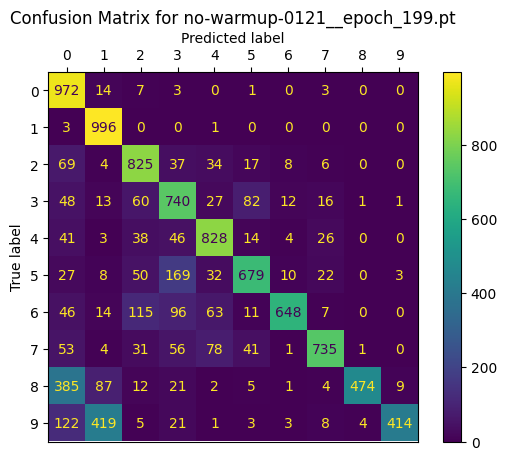

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots()
cmp = ConfusionMatrixDisplay.from_predictions(y_true=valid_labels, y_pred=valid_preds, ax=ax)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.set_title(f"Confusion Matrix for {CONFIG.checkpoint_filename}")
fig.show()